# Autoencoder for Super Resolution on Fashion MNIST

This AutoEncoder (AE) will try to remove the random noise on the pictures of clothings.<br>
The input data is the famous Fahsion MNIST with thousands of 28x28 pictures. <br>
Gaussian noise was added on the input data. <br>
The target images are the original images from the dataset.<br>
The input to the AE are the pictures that with additional noise.

## Import Modules

In [11]:
# visualization of images and analytic cruves
import matplotlib.pyplot as plt
# analytics
import numpy as np
# dl framework
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision
# accelerated dl framework
import pytorch_lightning as pl
from pytorch_lightning.trainer import Trainer

## Download Data and Transform

In [12]:
# download full dataset for trainin and validation
mnist_dataset = torchvision.datasets.FashionMNIST(root="",
                                                  transform=torchvision.transforms.Compose([
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.5,), (0.5,))]),
                                                  train=True,
                                                  download=True)

# split the entire dataset into validation and training set
mnist_train_dataset, mnist_val_dataset = random_split(dataset=mnist_dataset, 
                                                      lengths=[0.9, 0.1])

# download the test data
mnist_test_dataset = torchvision.datasets.FashionMNIST(root="",
                                                  transform=torchvision.transforms.Compose([
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.5,), (0.5,))]),
                                                  train=False,
                                                  download=True)

In [13]:
batch_size = 32
shuffle = True
# train dataloader
mnist_train_dataloader = DataLoader(mnist_train_dataset,
                              batch_size=batch_size,
                              shuffle=shuffle)

# val dataloader
mnist_train_dataloader = DataLoader(mnist_val_dataset,
                              batch_size=batch_size,
                              shuffle=shuffle)

# test dataloader
mnist_test_dataloader = DataLoader(mnist_test_dataset,
                              batch_size=batch_size,
                              shuffle=shuffle)

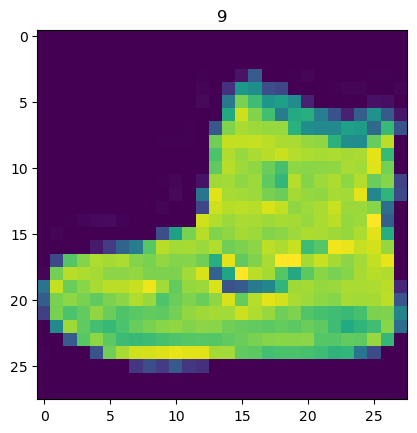

In [28]:
# plot image dependent on the index in the dataset
def visualize_picture(index: int) -> None:
    img = np.array(mnist_dataset[index][0]).reshape(28, 28)
    label = mnist_dataset[index][1]
    plt.imshow(img)
    plt.title(label)

# example of mnist image
visualize_picture(0)

## Define AutoEncoder

In [29]:
# autoencoder in class structure
class SRAE(pl.LightningModule):
    def __init__(self, 
                 latent_dim=20):
        super().__init__()

        # number of latent dim
        self.latent_dim = latent_dim

        # encoding procedure
        self.encode = nn.Sequential(
            nn.Conv2d(1, 16, 
                      kernel_size=3,
                      stride=2, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 
                      kernel_size=3, 
                      stride=2, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 
                      kernel_size=3, 
                      stride=2, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 
                      kernel_size=3, 
                      stride=2, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 
                      kernel_size=3, 
                      stride=2, 
                      padding=1),
            nn.ReLU()
        )

        # decoding procedure
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )


    def forward(self,x):

        # encode input to latent space
        encoded = self.encode(x)
        print(encoded.shape)

        encoded = encoded.view(encoded.size(0), -1)
        latent = encoded[:, :self.latent_dim]
        
        # decode from latent space
        decoded = self.decode(latent.unsqueeze(-1).unsqueeze(-1))
        return decoded

    def training_step(self, batch, batch_idx):
        # extract the image from the bact
        x, _ = batch

        # adding gaussiona noise to the image

        # predicted image from AE 
        x_hat = self(x)

        # using mean squared error to calculate 
        # the distance to the true values
        loss = nn.functional.MSE(x_hat, x)

        # log the loss for better visualization
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # extract the image from the bact
        x, _ = batch

        # adding gaussiona noise to the image

        # predicted image from AE 
        x_hat = self(x)

        # using mean squared error to calculate 
        # the distance to the true values
        loss = nn.functional.MSE(x_hat, x)

        # log the loss for better visualization
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        # extract the image from the bact
        x, _ = batch

        # adding gaussiona noise to the image

        # predicted image from AE 
        x_hat = self(x)

        # using mean squared error to calculate 
        # the distance to the true values
        loss = nn.functional.MSE(x_hat, x)

        # log the loss for better visualization
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        # adam optimizer
        optim = Adam(params= self.parameters(),
                     lr=1e-3)
        return optim

## Train AutoEncoder

In [30]:
model = SRAE()
trainer = Trainer(max_epochs=5)
trainer.fit(model=model,
            train_dataloaders=mnist_train_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/leonrenn/opt/miniconda3/envs/data_augmentation/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name   | Type       | Params
--------------------------------------
0 | encode | Sequential | 392 K 
1 | decode | Sequential | 392 K 
--------------------------------------
784 K     Trainable params
0         Non-trainable params
784 K     Total params
3.138     Total estimated model params size (MB)
/Users/leonrenn/opt/miniconda3/envs/data_augmentation/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value o

Epoch 0:   0%|          | 0/188 [00:00<?, ?it/s] torch.Size([32, 256, 1, 1])


RuntimeError: Given transposed=1, weight of size [256, 128, 3, 3], expected input[32, 20, 1, 1] to have 256 channels, but got 20 channels instead

## Performance on Test

## Summary